# House Sales in King County, USA

    The purpose of this notebook is to gain a deeper understanding of linear regression by applying it to the "House Sales 
    in King County" dataset. I will aim to archieve the highest possible prediction score by checking the underlying 
    assumptions of a linear regression model and taking appropiate actions if needed.

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('kc_house_data.csv')

# 1.) Data Preparation

## 1.1.) Missing Values

In [3]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

We don't hava any missing values in our dataset

## 1.2.) Categorical Variables

In [4]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [5]:
df.drop(columns=['id', 'date'], inplace=True)

    All our variables are numercial except for 'date'. Even though being numerical, variables like view, condition, etc. can be considered as categorical since they are not continuous. For those variables we could use an encoding method (e.g. 
    dummy variables). However, I've decided to not consider those variables as categorical. 
    Since I decided to not include 'date' in the regression, I will drop it along with 'id'.

# 2.) Regression

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import preprocessing

In [7]:
X = df.drop(columns=['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [8]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
print("Training set score: {:.7f}".format(model_lr.score(X_train, y_train)))
print("Test set score: {:.7f}".format(model_lr.score(X_test, y_test)))
print("RMSE: {:.7f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

Training set score: 0.6945470
Test set score: 0.7097660
RMSE: 200082.3905667


    With just a simple multiple regression we can already archive a r2-score of ~0.7. This is not optimal but not too bad 
    for now.

# 3.) Check Model Adequacy

    To improve our score we should take a look at the assumptions our model is making. We are using linear regression so we should check our data regarding:
    
    - Linearity
    - Outliers
    - Homoscedasticity
    - Normality
    - Multicollinearity


## 3.1.) Linearity

### Actual vs. Predicted Plot

In [9]:
def calculate_residuals(model, features, label):
    predictions = model_lr.predict(features)
    df_result = pd.DataFrame({'Actual':label, 'Predicted':predictions})
    df_result['Residuals'] = abs(df_result['Actual']) - abs(df_result['Predicted'])
    return df_result

In [10]:
def linear_assumption(model, features, label):
    df_result = calculate_residuals(model, features, label)
    fig1, ax1 = plt.subplots(figsize=(12,8))
    ax1 = sns.regplot(x='Actual', y='Predicted', data=df_result, color='steelblue')
    line_coords = np.arange(df_result.min().min(), df_result.max().max())
    ax1 = plt.plot(line_coords, line_coords,  # X and y points
              color='indianred')

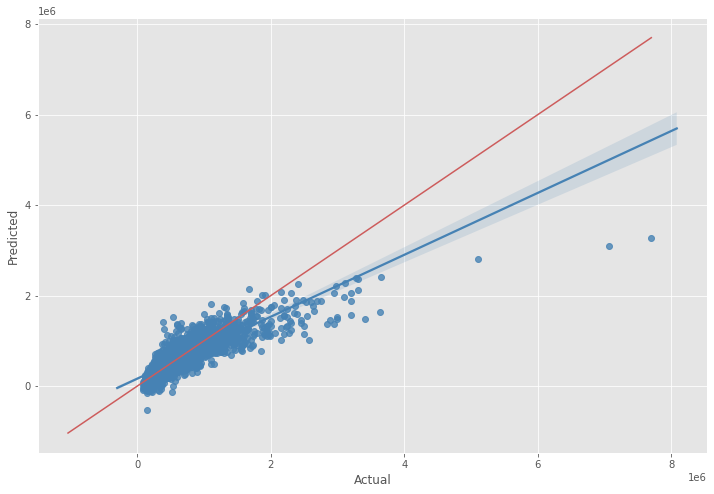

In [11]:
linear_assumption(model_lr, X_test, y_test)

### Residual Plot

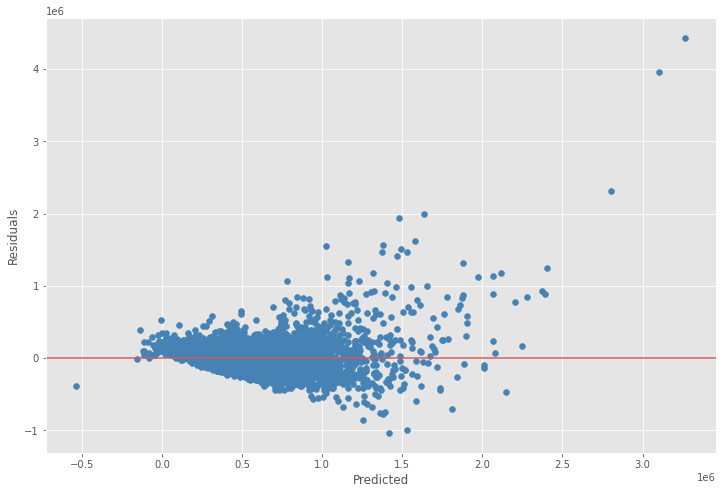

In [12]:
df_result = calculate_residuals(model_lr, X_test, y_test)
fig2, ax2 = plt.subplots(figsize=(12,8))
ax2.scatter(x=df_result['Predicted'], y=df_result['Residuals'], color='steelblue')
plt.axhline(y=0, color='indianred')
ax2.set_ylabel('Residuals', fontsize=12)
ax2.set_xlabel('Predicted', fontsize=12)
plt.show()

    We can check the linearity of our model by looking at the actual vs. predicted plot or the predicted vs. residuals plot. For linearity in case of the former, the data points should be symmetrically distributed around the diagonal line. This is not the case here as our predictions are biased especially with higher values. Similarly, for linearity in case of 
    the latter, the data points should be symmetrically distributed around the horizontal line. As observed though, the 
    residual variance increases with higher values. This indicates the violation of the underlying assumptions and are dealt with in a later section. (I found the functions on this blog: https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/)

## Outliers

    Before we get back to the linearity assumption, we will focus on a different problem that is appearent in the plots: Outliers. Our model failed to predict certain values by a significant amount, thus it is worth it to have a look at the 
    price distribution.

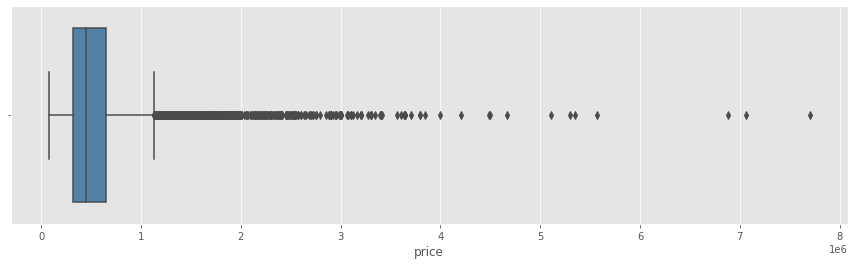

In [13]:
plt.style.use('ggplot')
fig3, ax3 = plt.subplots(figsize=(15,4))
ax3 = sns.boxplot(x=df['price'], color='steelblue')

In [14]:
df1 = df[~(df['price']>4000000)]
df1

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


    We can see from the boxplot that there are just a few data points where the price exceeds 4,000,000. After examining the data points I reached the conclusion that these "outliers" are not due to a mistake (false entry, etc.) because the high prices seem plausible to some degree given the underlying attributes (sqft_living, grade, etc.). However, I will omit all the data where the price exceeds 4,000,000 as there are only 11 entries and the regression is affected (as shown in the residual and the actual vs. predicted plots). This implies that our model only applies to a certain price range 
    (price < 4,000,000)

## Regression without outliers

In [15]:
X1 = df1.drop(columns=['price'])
y1 = df1['price']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=10)

In [16]:
model_lr1 = LinearRegression()
model_lr1.fit(X1_train, y1_train)
y1_pred = model_lr1.predict(X1_test)
print("Training set score: {:.7f}".format(model_lr1.score(X1_train, y1_train)))
print("Test set score: {:.7f}".format(model_lr1.score(X1_test, y1_test)))
print("RMSE: {:.7f}".format(np.sqrt(metrics.mean_squared_error(y1_test, y1_pred))))

Training set score: 0.7028867
Test set score: 0.7152921
RMSE: 188586.0068807


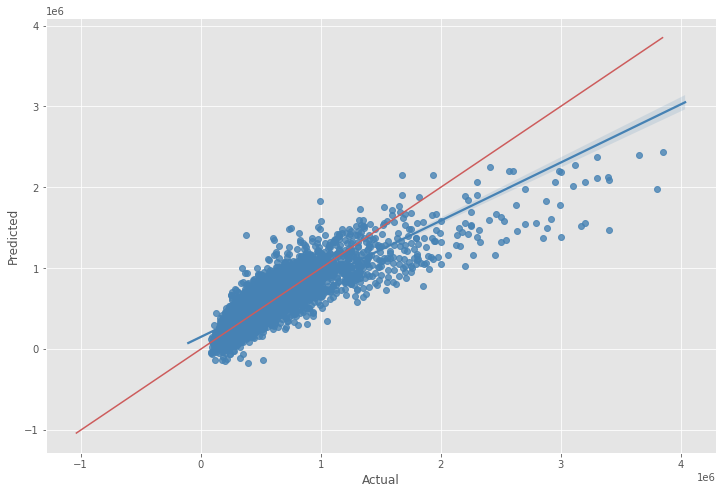

In [17]:
linear_assumption(model_lr1, X1_test, y1_test)

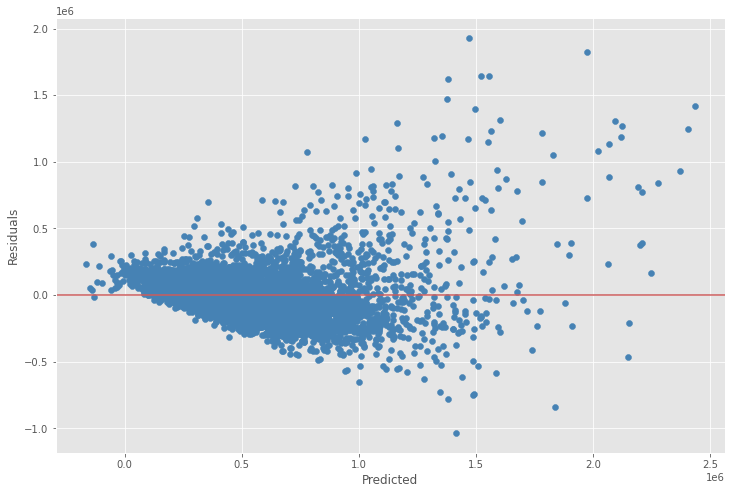

In [18]:
df_result = calculate_residuals(model_lr1, X1_test, y1_test)
fig4, ax4 = plt.subplots(figsize=(12,8))
ax4.scatter(x=df_result['Predicted'], y=df_result['Residuals'], color='steelblue')
ax4.set_ylabel('Residuals', fontsize=12)
ax4.set_xlabel('Predicted', fontsize=12)
plt.axhline(y=0, color='indianred')
plt.show()

    Omitting the "outliers" in the regression model led to a slight improvement of the score. We also got rid of the outliers from our actual vs. predicted and residual plots. However, the problem of non-linearity still remains. Let's dive 
    deeper into that.

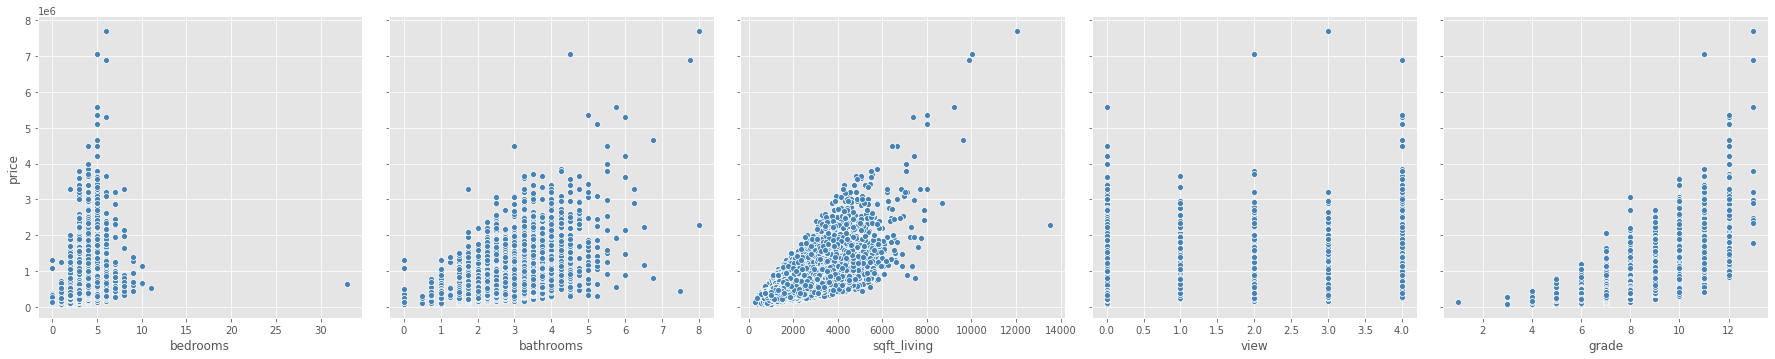

In [19]:
plt.style.use('ggplot')
sns.pairplot(df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'view', 'grade']],  
             y_vars=['price'], x_vars=['bedrooms', 'bathrooms', 'sqft_living', 'view', 'grade'], 
             height=5, plot_kws={'color':'steelblue'}) 
plt.show()

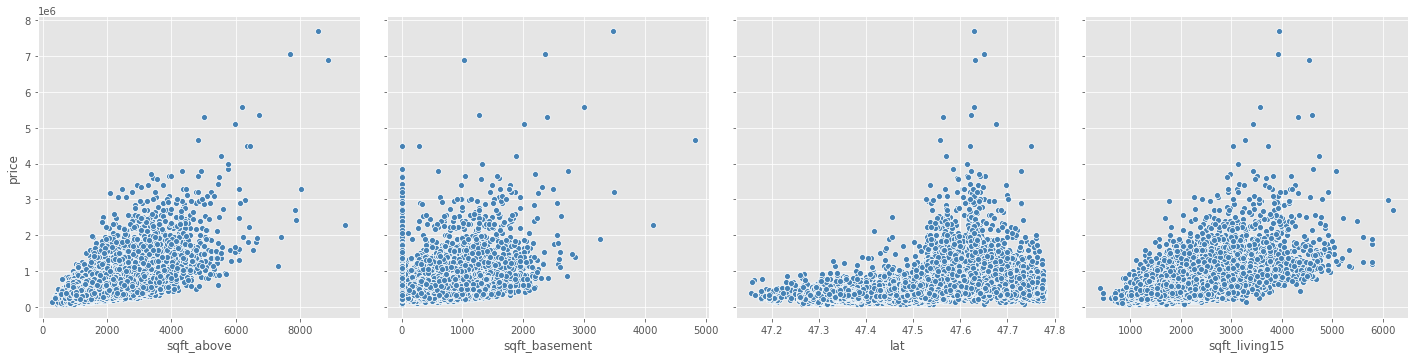

In [20]:
plt.style.use('ggplot')
sns.pairplot(df[['price','sqft_above', 'sqft_basement', 'lat', 'sqft_living15']],  
             y_vars=['price'], x_vars=['sqft_above', 'sqft_basement', 'lat', 'sqft_living15'], height=5,
             plot_kws={'color':'steelblue'}) 
plt.show()

    Based on the correlation plot I chose to plot the relationship of the variable price and the above seen variables. None of the independent variables show perfect linearity. The variables sqft_living, sqft_above and sqft_living15 show 
    certain degrees of linearity. However, this is not optimal for our regression model. To deal with the non-linearity we 
    will try to perform a polynomial regression.

## Polynomial Regression

In [21]:
from sklearn.preprocessing import PolynomialFeatures

In [22]:
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X1_train)
X_test_poly = poly.fit_transform(X1_test)

In [23]:
model_lr_poly = LinearRegression()
model_lr_poly.fit(X_train_poly, y1_train)
y_pred_poly = model_lr_poly.predict(X_test_poly)
print("Training set score: {:.7f}".format(model_lr_poly.score(X_train_poly, y1_train)))
print("Test set score: {:.7f}".format(model_lr_poly.score(X_test_poly, y1_test)))
print(np.sqrt(metrics.mean_squared_error(y1_test, y_pred_poly)))

Training set score: 0.8151084
Test set score: 0.8182882
150661.12150759288


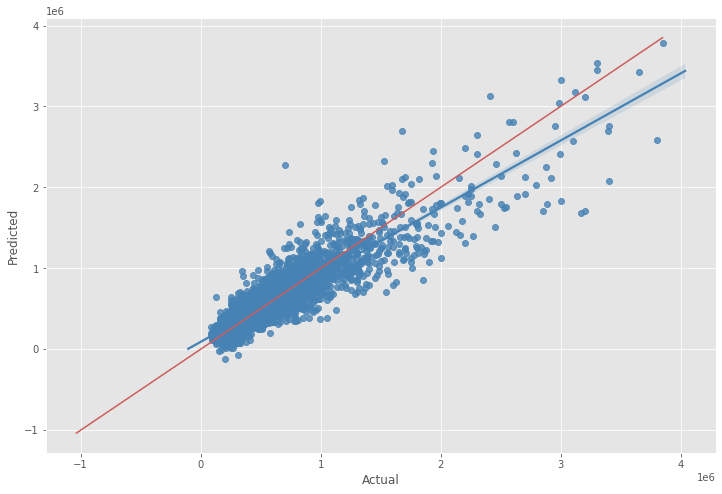

In [24]:
fig10, ax10 = plt.subplots(figsize=(12,8))
ax10 = sns.regplot(x=y1_test, y=y_pred_poly, color='steelblue')
line_coords = np.arange(df_result.min().min(), df_result.max().max())
plt.plot(line_coords, line_coords, color='indianred')
ax10.set_ylabel('Predicted', fontsize=12)
ax10.set_xlabel('Actual', fontsize=12)
plt.show()

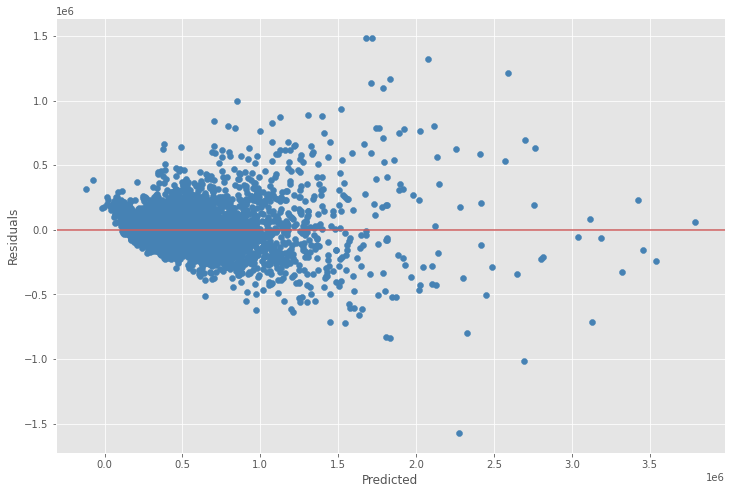

In [25]:
df_result = calculate_residuals(model_lr1, X1_test, y1_test)
fig11, ax11 = plt.subplots(figsize=(12,8))
ax11.scatter(x=y_pred_poly, y=y1_test-y_pred_poly, color='steelblue')
ax11.set_ylabel('Residuals', fontsize=12)
ax11.set_xlabel('Predicted', fontsize=12)
plt.axhline(y=0, color='indianred')
plt.show()

    A polynomial regression (degree: 2), often considered a special kind of linear regression, significantly improves our r2 score! The distributions of the data points in our actual vs. predicted and residual plots looks better too. However, we can still observe what seems to be outliers and inaccurities. As mentioned earlier, especially in the residual plot we 
    can still see increased variances with higher values. This is an indicator for heteroscedasticity.

## 3.2.) Homoscedasticity

    Homoscedasticity describes constant variance in the residuals as can be observed in a residual plot. Ideally, the 
    residuals should be distributed evenly around the horizontal line without any increasing or decreasing trend. This is 
    not the case in our residual plot so we will try to log-transform the dependent variable in order to tackle 
    heteroscedasticity.

In [26]:
X = df1.drop(columns=['price'])
price_trans = np.log1p(df1['price'])
X2_train, X2_test, y2_train, y2_test = train_test_split(X, price_trans, test_size=0.3, random_state=10)

In [27]:
poly = PolynomialFeatures(2)
X2_train_poly = poly.fit_transform(X2_train)
X2_test_poly = poly.fit_transform(X2_test)

In [28]:
model_lr_poly2 = LinearRegression()
model_lr_poly2.fit(X2_train_poly, y2_train)
y2_pred_poly = model_lr_poly2.predict(X2_test_poly)
print("Training set score: {:.7f}".format(model_lr_poly2.score(X2_train_poly, y2_train)))
print("Test set score: {:.7f}".format(model_lr_poly2.score(X2_test_poly, y2_test)))

Training set score: 0.8292655
Test set score: 0.8244047


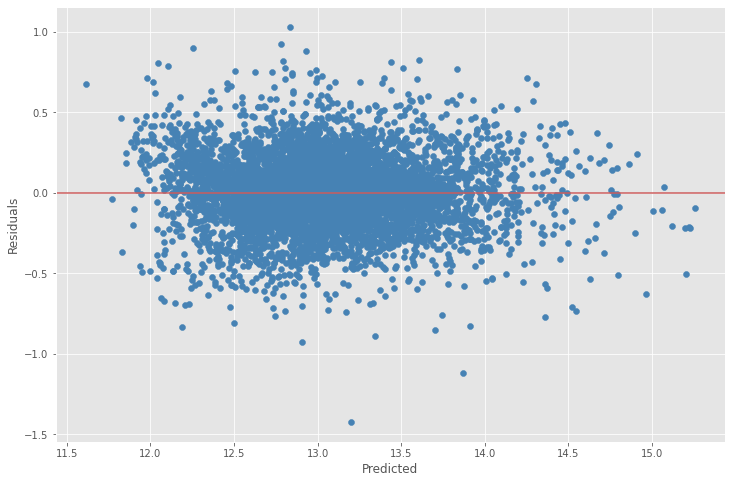

In [29]:
fig13, ax13 = plt.subplots(figsize=(12,8))
ax13.scatter(x=y2_pred_poly, y=y2_test-y2_pred_poly, color='steelblue')
ax13.set_ylabel('Residuals', fontsize=12)
ax13.set_xlabel('Predicted', fontsize=12)
plt.axhline(y=0, color='indianred')
plt.show()

    Transforming our dependent variable increased our r2 score slightly. More importantly, the residuals seem to be more 
    evenly distributed around the horizontal line than before. However, we can still observe many outliers. 
    (Any suggestions on how i should proceed with the outlier problem is welcomed)

## 3.3.) Normality

    The normality assumption can easily be observed by plotting the residual histogram or the QQ-plot of the residuals.

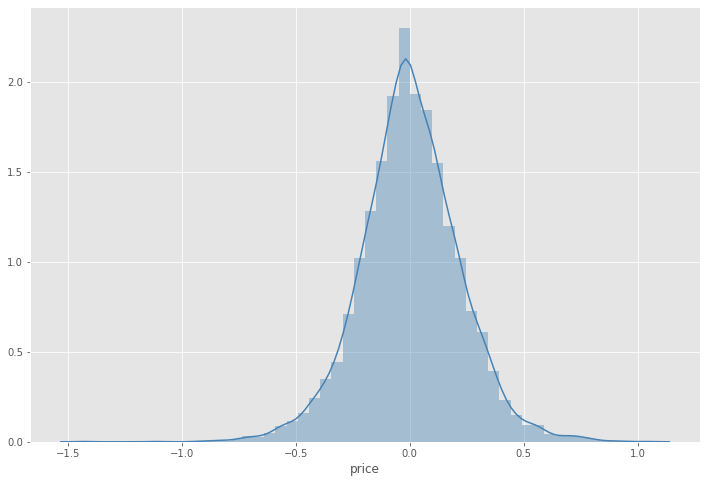

In [30]:
fig15, ax15 = plt.subplots(figsize=(12,8))
sns.distplot(y2_test-y2_pred_poly, color='steelblue')
plt.show()

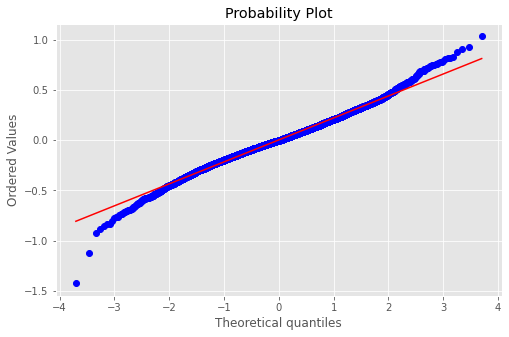

In [31]:
from scipy import stats
fig16, ax16 = plt.subplots(figsize=(8,5))
stats.probplot(y2_test-y2_pred_poly, plot=plt)
plt.show()

    Both plots show that the normality assumption is met. We archieved this by log-transforming our dependent variable in the previos step.

## 3.4.) Multicollinearity

## VIF

    One method to identify which variables are affected by multilinearity is the Variation Inflation Factor (VIF). A value 
    of >10 indicates multicollinearity. Let's check the VIF's for our X_test from the very first regression.

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_test.values, i) for i in range(X_test.shape[1])]
vif["features"] = X_test.columns

C:\Users\Nam\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [33]:
vif['VIF'] = vif['VIF'].apply(lambda x: "{:.2f}".format(x))
vif

,VIF,features
0,25.60,bedrooms
1,29.03,bathrooms
2,inf,sqft_living
3,2.07,sqft_lot
4,16.80,floors
5,1.23,waterfront
6,1.58,view
7,35.03,condition
8,141.27,grade
9,inf,sqft_above


    Apparently, most of our variables are affected by multicollinearity. This is a problem especially when interpreting the coefficients and the individual effects the independent variables have on the dependent variable. However, our goal here is primarily prediction precision, so we don't have to worry about collinearity too much.
    (this blog amongst others provide an overview on when multicollinearity needs to be tackled and when not: https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/).

# 4.) Conclusion

    After checking the underlying assumptions of a linear regression model and taking the appropiate actions, we archieved an r2 score of ~0.82. There is definitely room for improvement and we should also consider different regression models aswell. Any suggestions on how I could improve or make changes in the model would be highly appreciated.